In [2]:
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import json
import numpy as np
from zipfile import ZipFile
import glob
import zipfile
from sklearn.neighbors import BallTree
import numpy as np

In [3]:
def read_gdf_from_zip(zip_fp):
    """
    Reads multiple csv files from ZipFile into a Pandas dataframe.
    """
    for zip_file in glob.glob(zip_fp):
        zf = zipfile.ZipFile(zip_file)
        dfs = [pd.read_csv(zf.open(f),sep=",") for f in zf.namelist()]
        sim_df = pd.concat(dfs,ignore_index=True)
    
    return sim_df

In [4]:
snapshot = read_gdf_from_zip('/Users/vsundar/Documents/personal/smc/data/vehicle_data/Simulation_Snapshot/snapshot.zip')

In [32]:
def start_end(sim_df):
    """
    Reads a spatial dataset from ZipFile into GeoPandas. Assumes that there is only a single file (such as GeoPackage)
    inside the ZipFile.
    """
    sim_snap_df = sim_df.groupby('VEHICLE')   
    sim_start = pd.DataFrame(sim_snap_df.head(1))
    sim_end = pd.DataFrame(sim_snap_df.tail(1))
    sim_end.X_COORD = pd.to_numeric(sim_end.X_COORD)
    sim_end.Y_COORD = pd.to_numeric(sim_end.Y_COORD)
    sim_start.X_COORD = pd.to_numeric(sim_start.X_COORD)
    sim_start.Y_COORD = pd.to_numeric(sim_start.Y_COORD)
    sim_start_gdf = gpd.GeoDataFrame(sim_start, geometry=gpd.points_from_xy(sim_start.X_COORD,sim_start.Y_COORD))
    sim_start_gdf.crs="EPSG:26916"
    sim_start_wgs84 = sim_start_gdf.to_crs(epsg=4326)
    sim_end_gdf = gpd.GeoDataFrame(sim_end, geometry=gpd.points_from_xy(sim_end.X_COORD,sim_end.Y_COORD))
    sim_end_gdf.crs="EPSG:26916"
    sim_end_wgs84 = sim_end_gdf.to_crs(epsg=4326)
    
    return sim_start_wgs84, sim_end_wgs84

In [33]:
sim_start,sim_end = start_end(snapshot)


,VEHICLE,TIME,LINK,DIR,LANE,OFFSET,SPEED,ACCEL,VEH_TYPE,DRIVER,PASSENGERS,X_COORD,Y_COORD,geometry
5,245126,0:03,804,1,1,30.0,0.0,0.0,1,24512601,0,447505.381060,4.638411e+06,POINT (-87.63283 41.89589)
16,166155,2:45,1696,0,3,37.5,0.0,0.0,1,16615501,0,446958.506431,4.635791e+06,POINT (-87.63918 41.87226)
17,127167,2:47:30,214,1,3,120.0,0.0,0.0,1,12716701,0,446824.617870,4.636856e+06,POINT (-87.64089 41.88185)
23,241483,2:48:30,1369,0,2,60.0,22.5,7.5,1,24148301,0,447554.732135,4.635999e+06,POINT (-87.63202 41.87417)
26,202723,2:50,804,1,1,34.7,7.5,7.5,1,20272301,0,447503.868258,4.638500e+06,POINT (-87.63285 41.89669)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24846666,176652,1@0:59:30,972,0,1,75.0,0.0,0.0,1,17665201,0,447608.505670,4.634674e+06,POINT (-87.63125 41.86224)
24846667,174758,1@0:59:30,972,0,1,67.5,0.0,0.0,1,17475801,0,447605.849683,4.634810e+06,POINT (-87.63130 41.86347)
24846668,93763,1@0:59:30,63,0,2,82.5,0.0,-7.5,1,9376301,0,447600.676242,4.636580e+06,POINT (-87.63151 41.87941)
24846669,174635,1@0:59:30,972,0,1,60.0,0.0,0.0,1,17463501,0,447603.193859,4.634946e+06,POINT (-87.63134 41.86469)


In [83]:

left_geom_col =sim_start.geometry.name
left_radians = np.array(sim_start[left_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())

# sim_start[left_geom_col]
# right_geom_col = building_map.centroid
right_radians = np.array(building_map.centroid.apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())

building_map.centroid

array([[-1.52961219,  0.73123747],
       [-1.52961219,  0.73123747],
       [-1.52961219,  0.73123747],
       ...,
       [-1.5293626 ,  0.73050631],
       [-1.5293626 ,  0.73050631],
       [-1.5293626 ,  0.73050631]])

In [93]:
sim_start.geometry


0           POINT (-87.63313 41.88627)
6           POINT (-87.63187 41.88196)
17          POINT (-87.64089 41.88185)
18          POINT (-87.62976 41.87347)
19          POINT (-87.63502 41.88627)
                       ...            
24846666    POINT (-87.63125 41.86224)
24846667    POINT (-87.63130 41.86347)
24846668    POINT (-87.63151 41.87941)
24846669    POINT (-87.63134 41.86469)
24846670    POINT (-87.62410 41.87218)
Name: geometry, Length: 107758, dtype: geometry

In [34]:
def building_prep(building_map:str):
    """ 
    Reads building geojson and prepares data for calculating nearest distance metrics.
    """
    building_map = gpd.read_file(building_map)
    building_map = building_map.assign(centroid=building_map.centroid)
    
    return building_map

In [57]:
building_map = building_prep(building_map= "/Users/vsundar/Documents/personal/smc/smc-cuda-intersect/data/building_data/Building_Footprints/ChicagoLoop_attr.geojson")
building_map.centroid


0        POINT (-87.64032 41.89682)
1        POINT (-87.64032 41.89682)
2        POINT (-87.64032 41.89682)
3        POINT (-87.64032 41.89682)
4        POINT (-87.64032 41.89682)
                    ...            
19804    POINT (-87.62602 41.85493)
19805    POINT (-87.62602 41.85493)
19806    POINT (-87.62602 41.85493)
19807    POINT (-87.62602 41.85493)
19808    POINT (-87.62602 41.85493)
Length: 19809, dtype: geometry

<IPython.core.display.Javascript object>


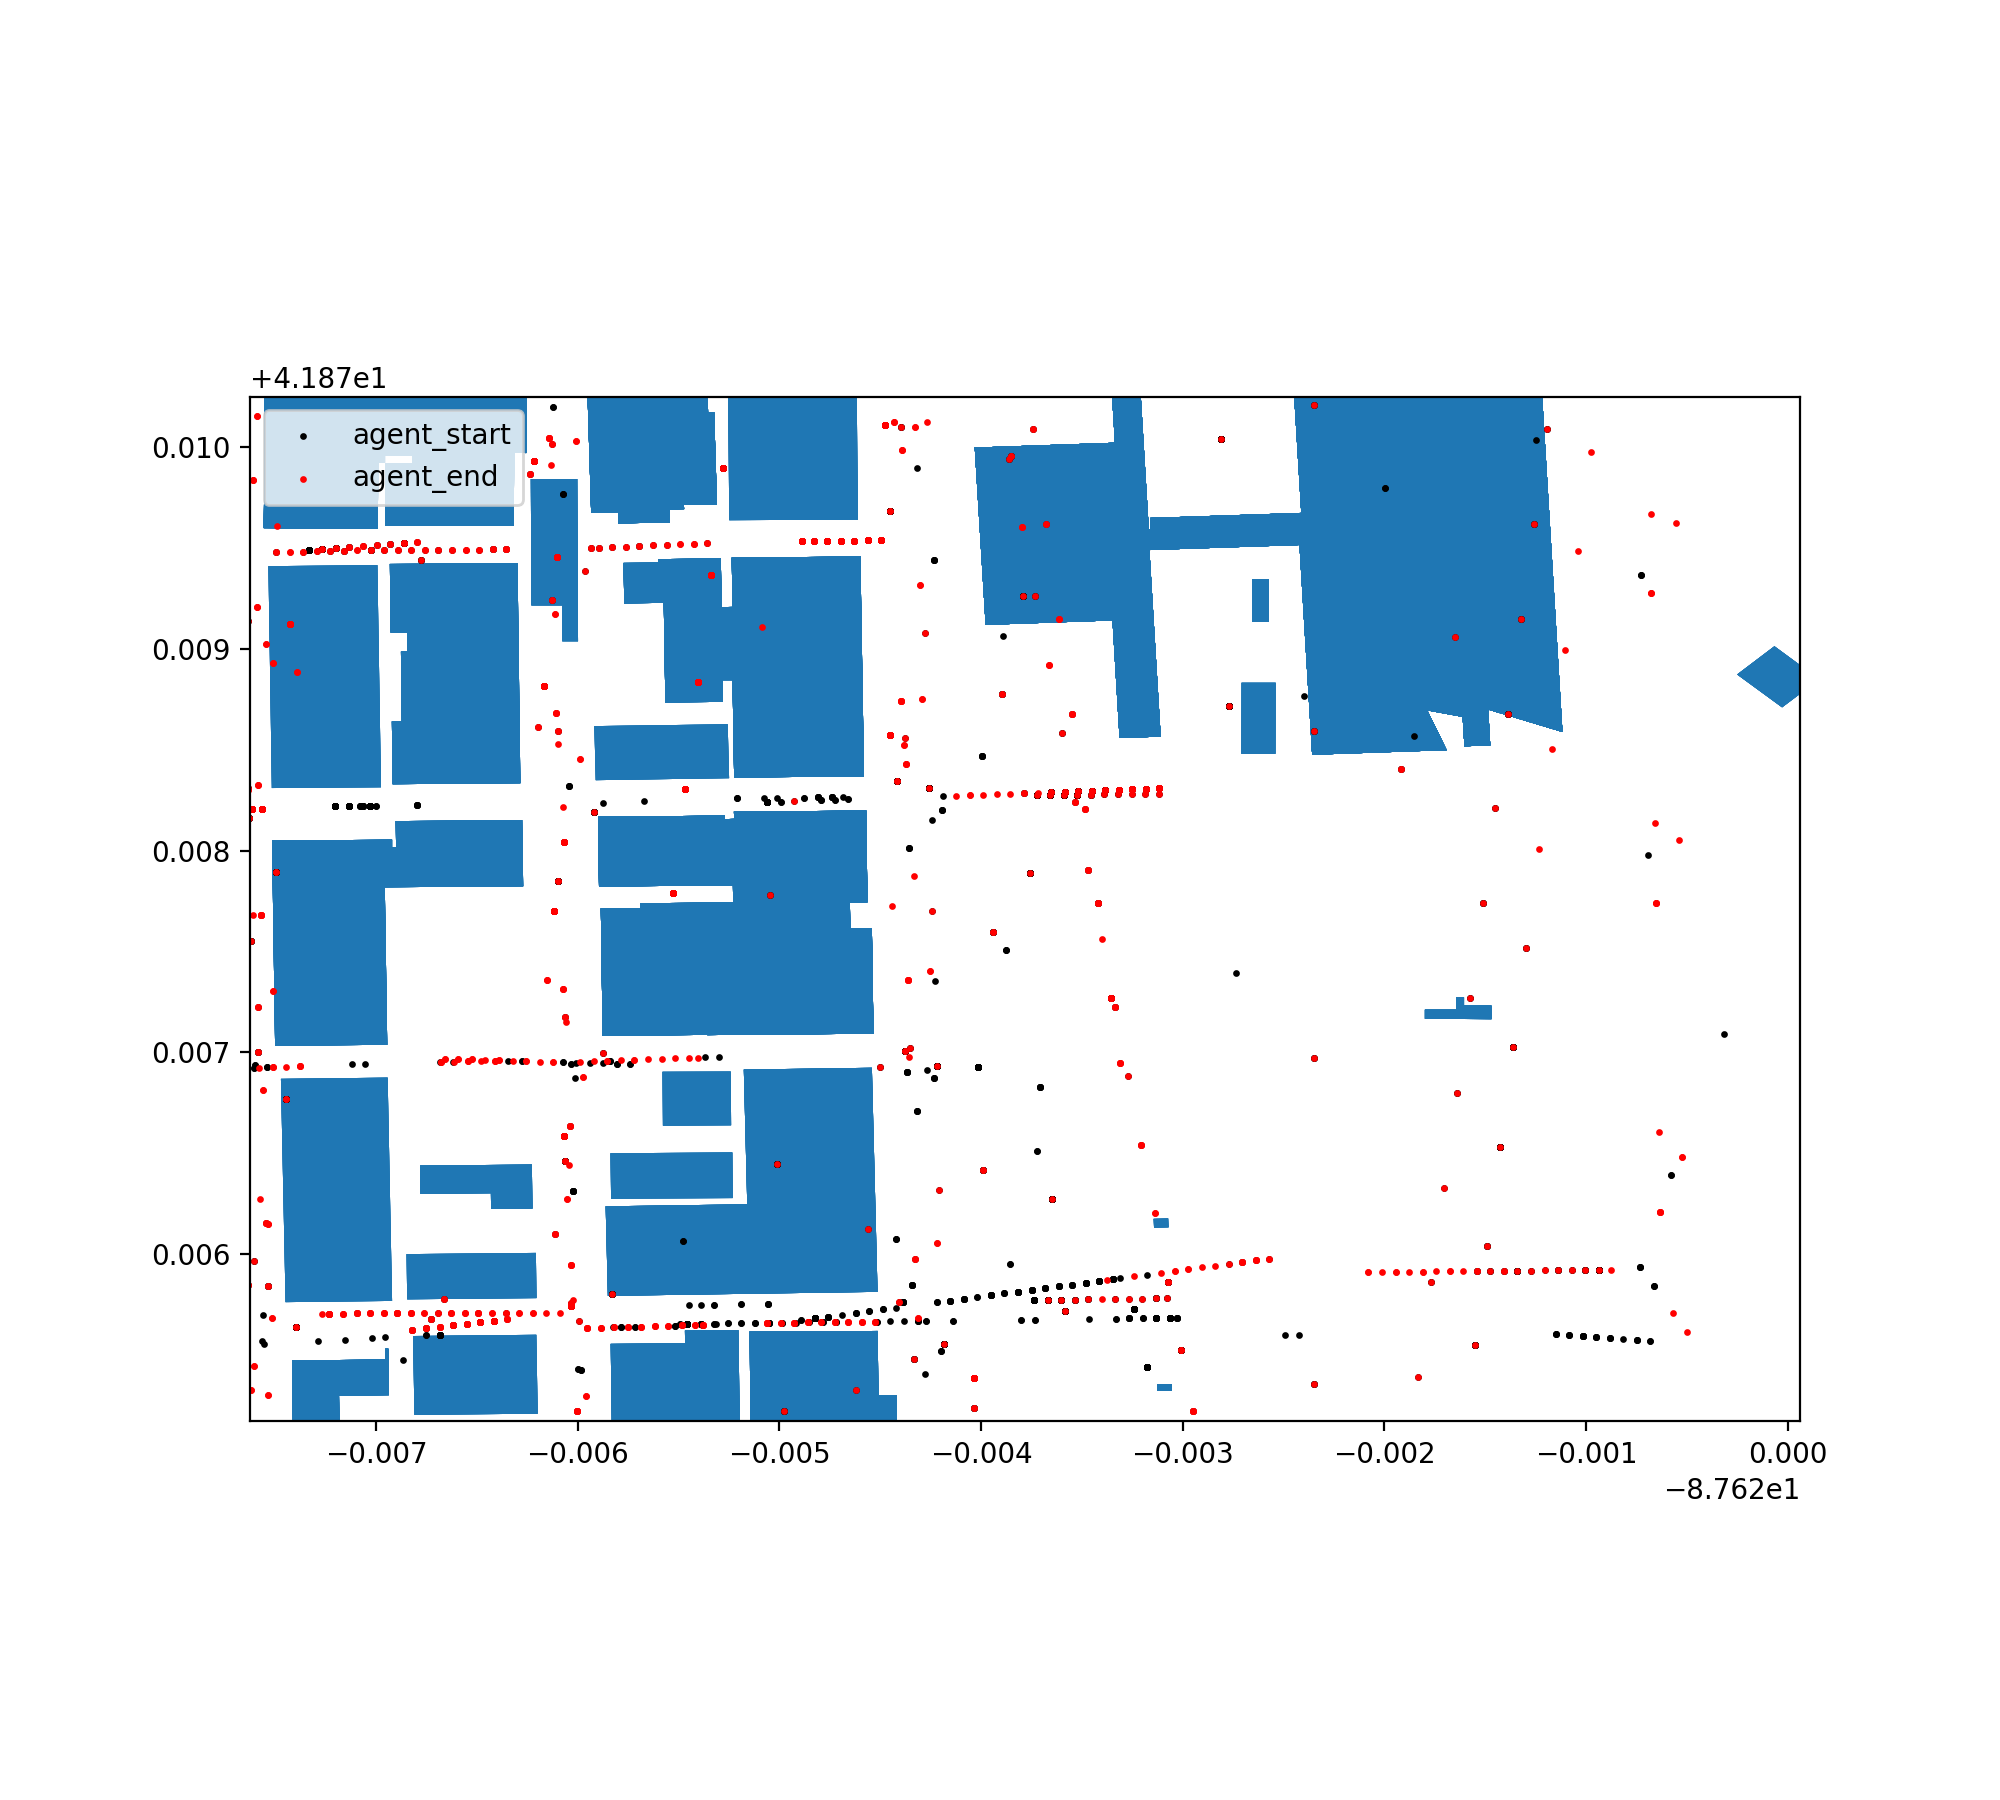

In [39]:
%matplotlib notebook

import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(10,9))
# Plot buildings and start and  
building_map.plot(ax=ax)
sim_start.plot(ax=ax, marker='o', color='black', markersize=2,label='agent_start')
sim_end.plot(ax=ax, marker='o', color='red', markersize=2,label='agent_end')
minx, miny, maxx, maxy = building_map.geometry.total_bounds
# # Margin around total bounds
ax.set_xlim(minx - 0.001, maxx + 0.001)
ax.set_ylim(miny - 0.001, maxy + 0.001)
ax.legend(loc='best')


In [40]:
from sklearn.neighbors import BallTree
import numpy as np

In [45]:
def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='haversine')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)

In [109]:
def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.
    NOTE: Input points are in wgs84.
    """
    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.centroid

    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)
    print(right)
#     # Parse coordinates from points and insert them into a numpy array as RADIANS
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    right_radians = np.array(right_geom_col.apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    
    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)
    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)
    print(closest)
    print(dist)
    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]
    print(closest_points)
    # Ensure that the index corresponds the one in left_gdf
    closest_points = closest_points.reset_index(drop=True)

    # Add distance if requested
    if return_dist:
        # Convert to meters from radians
        earth_radius = 6371000  # meters
        closest_points['distance'] = dist * earth_radius
        
    return closest_points

In [112]:
closest_buildings = nearest_neighbor(sim_start, building_map, return_dist=True)

               area  perimeter  \
0      3.938203e-08   0.000800   
1      3.938203e-08   0.000800   
2      3.938203e-08   0.000800   
3      3.938203e-08   0.000800   
4      3.938203e-08   0.000800   
...             ...        ...   
19804  5.412408e-07   0.003668   
19805  5.412408e-07   0.003668   
19806  5.412408e-07   0.003668   
19807  5.412408e-07   0.003668   
19808  5.412408e-07   0.003668   

                                                geometry  \
0      POLYGON ((-87.64041 41.89671, -87.64023 41.896...   
1      POLYGON ((-87.64041 41.89671, -87.64023 41.896...   
2      POLYGON ((-87.64041 41.89671, -87.64023 41.896...   
3      POLYGON ((-87.64041 41.89671, -87.64023 41.896...   
4      POLYGON ((-87.64041 41.89671, -87.64023 41.896...   
...                                                  ...   
19804  POLYGON ((-87.62637 41.85538, -87.62636 41.855...   
19805  POLYGON ((-87.62637 41.85538, -87.62636 41.855...   
19806  POLYGON ((-87.62637 41.85538, -87.62636 41.8

In [114]:
closest_buildings

,area,perimeter,geometry,centroid,distance
0,2.395448e-07,0.002148,"POLYGON ((-87.63336 41.88626, -87.63336 41.886...",POINT (-87.63304 41.88608),10.726353
1,3.445150e-07,0.003200,"POLYGON ((-87.63220 41.88135, -87.63150 41.881...",POINT (-87.63186 41.88161),1.782523
2,5.721586e-08,0.000980,"POLYGON ((-87.64069 41.88016, -87.64099 41.880...",POINT (-87.64084 41.88006),10.002872
3,2.779068e-07,0.002245,"POLYGON ((-87.63008 41.87315, -87.63007 41.872...",POINT (-87.62989 41.87278),15.212458
4,3.243570e-07,0.002472,"POLYGON ((-87.63527 41.88592, -87.63500 41.885...",POINT (-87.63507 41.88631),5.886509
...,...,...,...,...,...
107753,1.018295e-06,0.005014,"POLYGON ((-87.63150 41.86757, -87.63071 41.867...",POINT (-87.63108 41.86820),33.067615
107754,1.018295e-06,0.005014,"POLYGON ((-87.63150 41.86757, -87.63071 41.867...",POINT (-87.63108 41.86820),31.970550
107755,5.721568e-07,0.003311,"POLYGON ((-87.63093 41.87873, -87.63209 41.878...",POINT (-87.63151 41.87848),4.299824
107756,1.018295e-06,0.005014,"POLYGON ((-87.63150 41.86757, -87.63071 41.867...",POINT (-87.63108 41.86820),32.592867


In [118]:
print(len(closest_buildings),"==",len(sim_start))

107758 == 107758


In [ ]:
To do: Include the plots https://automating-gis-processes.github.io/site/notebooks/L3/nearest-neighbor-faster.html